# Oogeso - test case 2
Simple case for illustrating/testing the Oogeso model

In [214]:
%load_ext autoreload
%autoreload 2
#import matplotlib.pyplot as plt
import IPython
import pyomo.environ as pyo
import pandas as pd
import plotly.express as px
#import os
#import sys
#module_path = os.path.abspath(os.path.join('..'))
#if module_path not in sys.path:
#    sys.path.append(module_path)
import oogeso
from oogeso.io import file_io
from oogeso.dto.oogeso_input_data_objects import DataclassJSONEncoder

import logging
logging.basicConfig()
logger = logging.getLogger()
logger.setLevel('INFO')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [221]:
profiles_json = file_io.read_profiles_from_csv(
    filename_forecasts="testcase2_profiles_forecasts.csv",
    filename_nowcasts="testcase2_profiles_nowcasts.csv",timestamp_col="timestamp",exclude_cols=["timestep"],json_indent=0)
data0 = file_io.read_data_from_yaml('test case2.yaml',
    profiles=profiles_json["profiles"],
    profiles_nowcast=profiles_json["profiles_nowcast"])

KeyError: 'profiles_nowcast'

In [222]:
profiles_json.keys()

dict_keys(['profile', 'profile_nowcast'])

In [217]:
dfprof=file_io.reshape_timeseries(data0.profiles,start_time="2020-01-01",timestep_minutes=5)
#dfprof["nowcast:curve_wind"].plot()
dfprof["actual"]

Index(['nowcast:curve_wind', 'nowcast:curve_const', 'nowcast:curve_crude',
       'nowcast:curve_wind2', 'nowcast:demand', 'nowcast:wind'],
      dtype='object')
Index(['forecast:curve_wind', 'forecast:curve_const', 'forecast:curve_crude',
       'forecast:curve_wind2', 'forecast:wind3', 'forecast:demand',
       'forecast:wind'],
      dtype='object')


,nowcast:curve_wind,nowcast:curve_const,nowcast:curve_crude,nowcast:curve_wind2,nowcast:demand,nowcast:wind
2020-01-01 01:00:00+00:00,0.766447,1.0,1.000000,0.585784,1.0,1.000000
2020-01-01 01:05:00+00:00,0.766883,1.0,0.996042,0.585172,1.0,0.998333
2020-01-01 01:10:00+00:00,0.767319,1.0,0.992083,0.584559,1.0,0.996667
2020-01-01 01:15:00+00:00,0.767756,1.0,0.988125,0.583946,1.0,0.995000
2020-01-01 01:20:00+00:00,0.768192,1.0,0.984167,0.583333,1.0,0.993333
...,...,...,...,...,...,...
2020-01-04 23:40:00+00:00,0.518301,1.0,0.961167,0.345588,1.0,0.853333
2020-01-04 23:45:00+00:00,0.519339,1.0,0.964125,0.343750,1.0,0.855000
2020-01-04 23:50:00+00:00,0.520377,1.0,0.967083,0.341912,1.0,0.856667
2020-01-04 23:55:00+00:00,0.521414,1.0,0.970042,0.340074,1.0,0.858333


In [218]:
#with open("temporary.json", "w") as outfile:
#    json.dump(data0, fp=outfile, cls=DataclassJSONEncoder, indent=2)

In [164]:
prof1=data0.profiles["nowcast:curve_wind"]
df = pd.DataFrame.from_dict(prof1,orient="index")
df.index = pd.to_datetime(df.index)

In [165]:
df_comb = file_io.reshape_timeseris()

pandas._libs.tslibs.timestamps.Timestamp

In [14]:
data0 = file_io.read_data_from_yaml('test case2.yaml')
profiles = file_io.read_profiles_from_csv(
    filename_forecasts="testcase2_profiles_forecasts.csv",
    filename_nowcasts="testcase2_profiles_nowcasts.csv")
store_duals = {
    'elcost':{'constr':'constrDevicePmin','indx':('dem',None)},
    #'wind': {'constr':'constrTerminalEnergyBalance','indx':('el','windfarm','out',None)},
    }
store_duals = {}

# MODIFY input data
for dev in ['GT1','GT2']:
    data0.devices[dev].is_on_init = 1
#data0.parameters.el_reserve_margin = 0

optimiser = oogeso.Optimiser(data=data0)
simulator = oogeso.Simulator(optimiser=optimiser)
#
#data = oogeso.file_io.create_initdata(data0)
#mc = oogeso.Multicarrier(loglevel="INFO")
#mc.createModelInstance(data,profiles)

INFO:root:profiles in use: ['demand', 'wind']
INFO:root:Using objective function  exportRevenue
INFO:root:No emission_rate_max limit specified
INFO:root:No emissionIntensityMax limit specified
INFO:root:No elBackupMargin limit specified
TYPE Energysystemdata =  <class 'oogeso.dto.oogeso_input_data_objects.EnergySystemData'>


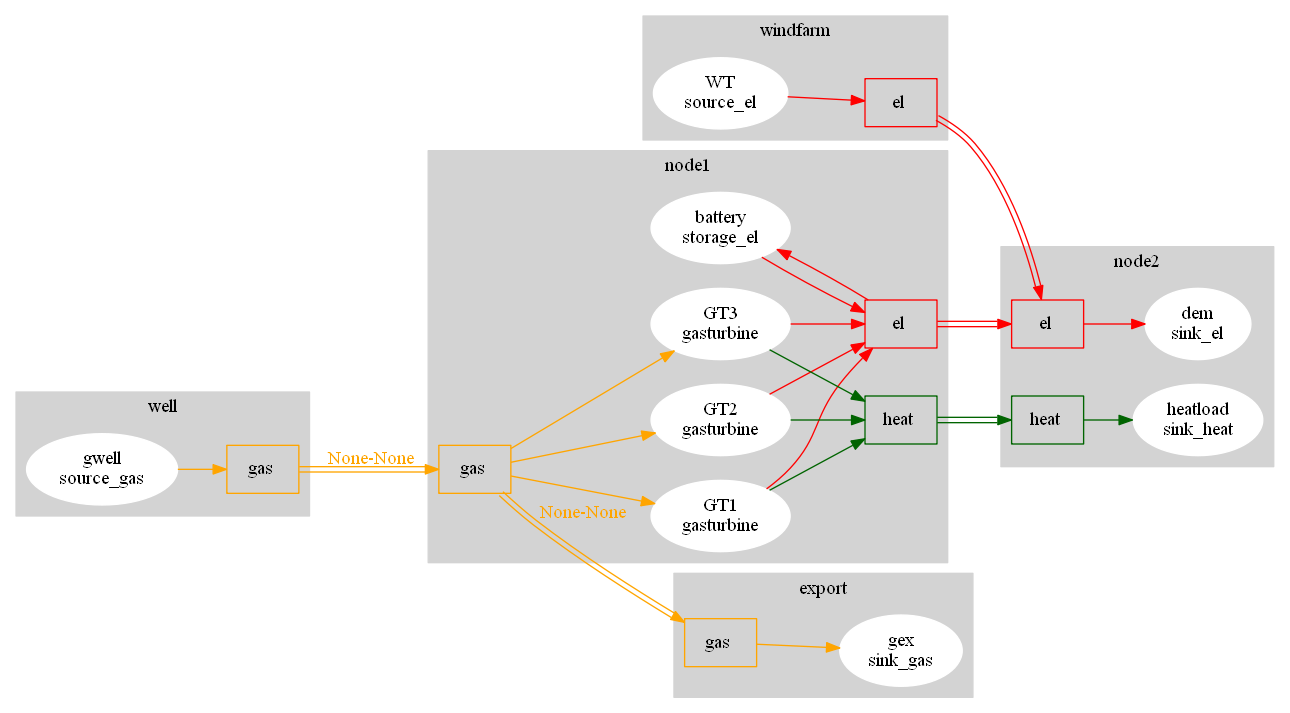

In [15]:
IPython.display.Image(oogeso.plots.plotNetwork(simulator=simulator,timestep=None).create_png())

In [16]:
status = simulator.runSimulation(solver="cbc",profiles=profiles,timerange=[0,90],write_yaml=False,
                     store_duals=store_duals)

100%|██████████| 23/23 [00:06<00:00,  3.35it/s]


In [19]:

#optimiser.pyomo_instance.constrTerminalEnergyBalance['el','node1','out',0].pprint()
#optimiser.pyomo_instance.constrTerminalEnergyBalance['el','node1','in',0].pprint()
#optimiser.pyomo_instance.constrDevice_ramprate['GT2',1].pprint()

#mc.instance.pprint()

In [57]:
gt='GT2'
print("GT is on initially ={}".format(pyo.value(optimiser.pyomo_instance.paramDeviceIsOnInitially[gt])))
print("GT timesteps in startup preparation = {}".format(pyo.value(optimiser.pyomo_instance.paramDevicePrepTimestepsInitially[gt])))
for t in range(4):
    cstr=getattr(optimiser.pyomo_instance, "constr_{}_startstop".format(gt))[t]
    #cstr=optimiser.pyomo_instance.constrDevice_startup_shutdown[gt,t]
    print("t={}: {} = {}".format(t,cstr.body,cstr.upper))
for t in range(4):
    cstr=getattr(optimiser.pyomo_instance, "constr_{}_startdelay".format(gt))[t]
    #cstr=optimiser.pyomo_instance.constrDevice_startup_delay[gt,t]
    print("t={}: {} = {}".format(t,cstr.body,cstr.upper))
for t in range(4):
    cstr=getattr(optimiser.pyomo_instance, "constr_{}_Pmax".format(gt))[t]
    #cstr=optimiser.pyomo_instance.constrDevicePmax[gt,t]
    print("t={}: {} = {}".format(t,cstr.body,cstr.upper))

GT is on initially =0.0
GT timesteps in startup preparation = 0
t=0: varDeviceIsOn[GT2,0] - paramDeviceIsOnInitially[GT2] + varDeviceStopping[GT2,0] = 0.0
t=1: varDeviceIsOn[GT2,1] - varDeviceIsOn[GT2,0] + varDeviceStopping[GT2,1] = 0.0
t=2: varDeviceIsOn[GT2,2] - varDeviceIsOn[GT2,1] + varDeviceStopping[GT2,2] = 0.0
t=3: varDeviceIsOn[GT2,3] - varDeviceIsOn[GT2,2] - (varDeviceStarting[GT2,0] - varDeviceStopping[GT2,3]) = 0.0
t=0: varDeviceIsPrep[GT2,0] - varDeviceStarting[GT2,0] = 0.0
t=1: varDeviceIsPrep[GT2,1] - (varDeviceStarting[GT2,1] + varDeviceStarting[GT2,0]) = 0.0
t=2: varDeviceIsPrep[GT2,2] - (varDeviceStarting[GT2,2] + varDeviceStarting[GT2,1] + varDeviceStarting[GT2,0]) = 0.0
t=3: varDeviceIsPrep[GT2,3] - (varDeviceStarting[GT2,3] + varDeviceStarting[GT2,2] + varDeviceStarting[GT2,1]) = 0.0
t=0: varDeviceFlow[GT2,el,out,0] - 20*varDeviceIsOn[GT2,0] = 0.0
t=1: varDeviceFlow[GT2,el,out,1] - 20*varDeviceIsOn[GT2,1] = 0.0
t=2: varDeviceFlow[GT2,el,out,2] - 20*varDeviceIsOn[GT2

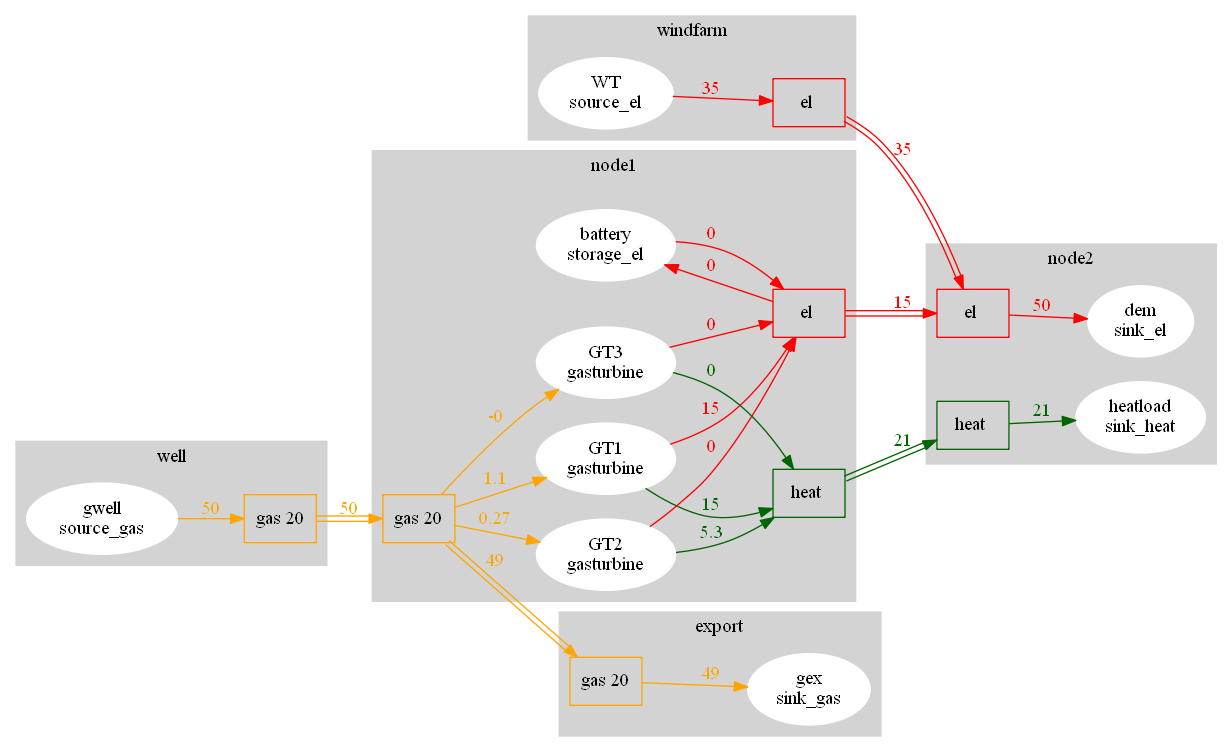

In [27]:
dotG=oogeso.plots.plotNetwork(simulator=simulator,timestep=15,filename=None)
#IPython.display.SVG(dotG.create_svg()) #original size, vector graphics
IPython.display.Image(dotG.create_png()) #scales automatically to page width

In [29]:
oogeso.plots.plot_SumPowerMix(simulator,carrier="el").show()

INFO:root:['GT1', 'GT2', 'GT3']


In [41]:
#mc=simulator
gts=['GT1','GT2','GT3']
if simulator._dfDuals.shape[0]>0:
    fig=px.line(simulator._dfDuals,title="Specific cost, marginal cost, dual value")
    cost_co2=mc.instance.paramParameters['co2_tax'] #NOK/kg

    # GTG specific cost (cost per power output)
    gtg_P=mc._dfDeviceFlow[:,'el','out',:].unstack('device')[gts] # MJ/s=MW
    gtg_co2=mc._dfCO2rate_per_dev[gts] # kg/s
    gtg_cost = cost_co2*gtg_co2/gtg_P # NOK/MJ
    gtg_avgcost = cost_co2*gtg_co2.sum(axis=1)/gtg_P.sum(axis=1) # NOK/kg x kg/s x 1/MW = NOK/MJ
    for col in gtg_cost:
        fig.add_scatter(y=gtg_cost[col],x=gtg_cost.index, mode="lines",name=col+' specific cost')
    fig.add_scatter(y=gtg_avgcost,x=gtg_avgcost.index, mode="lines",name='Average GTG specific cost',
                    line={'dash':'dash'})
    # GTG marginal costs:
    for gt in gts:
        fuelrate_per_power = (optimiser.all_devices[gt].dev_data.fuel_A
                            /optimiser.all_carriers['gas'].energy_value) #Sm3/MJ
        costrate = (optimiser.optimisation_parameters.co2_tax
                    *optimiser.all_carriers['gas'].co2_content
                    *fuelrate_per_power) # kr/MJ
        fig.add_scatter(y=[costrate,costrate],x=[gtg_avgcost.index[0],gtg_avgcost.index[-1]], 
                        mode="lines",name="{} marginal cost".format(gt))
    fig.update_xaxes(title_text='Timestep')
    fig.update_yaxes(title_text='Cost (NOK/MJ)')
    fig.show()

In [44]:
# Problem = isOn = isPrep, isStarting=0
gt='GT2'
dfStart=pd.concat([
    mc._dfDeviceStarting[gt],
    mc._dfDeviceIsPrep[gt],
    mc._dfDeviceIsOn[gt],
    mc._dfDeviceStopping[gt]],axis=1)
dfStart.columns=['starting','prep','on','stopping']
#dfStart[12:25]

In [ ]:
#mc.instance.varDeviceIsPrep.pprint()

In [45]:
oogeso.plots.plot_deviceprofile(mc,devs=['GT1','GT2','GT3'],includeOnOff=True,includePrep=True)

In [46]:
#plots.plot_CO2rate(mc)
oogeso.plots.plot_CO2rate_per_dev(mc)

In [47]:
oogeso.plots.plotReserve(mc)

In [48]:
oogeso.plots.plotElBackup(mc,showMargin=True)

In [51]:
dfplot=simulator._dfElReserve
margin=optimiser.optimisation_parameters.el_reserve_margin
x = [dfplot.index[0],dfplot.index[-1]]
fig=px.line(dfplot,title="Reserve")
fig.add_scatter(x=x,y=[margin,margin],line=dict(dash='dot'),name="margin",mode="lines")
fig.update_xaxes(title_text="Timestep")
fig.update_yaxes(title_text="Reserve power (MW)",dtick = 5)
fig.update_layout(autosize=False,width=800,height=300,margin=dict(l=0,r=0,t=30,b=0))

In [54]:
if 'battery' in optimiser.pyomo_instance.setDevice:
    fig=oogeso.plots.plot_devicePowerEnergy(mc,'battery',
                                 filename=None)
    fig.update_layout(autosize=False,width=800,height=300,margin=dict(l=0,r=0,t=30,b=0)).show()
    #print("Last optimisation scheduling:")
    #oogeso.milp_plot.plotDevicePowerLastOptimisation1(optimiser,device='battery',
    #            filename=None)